In [1]:
import torch
import cv2
from segment_anything import SamAutomaticMaskGenerator, sam_model_registry, SamPredictor
import numpy as np
import matplotlib.pyplot as plt
import glob
import torch
import clip
from PIL import Image
from tqdm import tqdm
import functions as fnc
from importlib import reload
from sklearn.cluster import KMeans
from scipy.ndimage import rotate
from scipy.spatial import ConvexHull, convex_hull_plot_2d
import gc
from skimage.measure import label, regionprops

In [2]:
OutDIR='/DATA/vito/output/'
DataDIR='/DATA/vito/data/'
MODEL_TYPE = "vit_h"

if torch.cuda.is_available():
    DEVICE = torch.device('cuda:0')
    print('Currently running on GPU\nModel '+MODEL_TYPE)
else:
    DEVICE = torch.device('cpu')
    print('Currently running on CPU\nModel '+MODEL_TYPE)

if MODEL_TYPE == 'vit_h':
    CHECKPOINT_PATH = DataDIR+'MetaSAM/sam_vit_h_4b8939.pth'
elif MODEL_TYPE == 'vit_l':
    CHECKPOINT_PATH = DataDIR+'MetaSAM/sam_vit_l_0b3195.pth'
else:
    CHECKPOINT_PATH = DataDIR+'MetaSAM/sam_vit_b_01ec64.pth'

sam = sam_model_registry[MODEL_TYPE](checkpoint=CHECKPOINT_PATH)
sam.to(device=DEVICE)
mask_generator = SamAutomaticMaskGenerator(sam)

Currently running on GPU
Model vit_h


In [3]:
#fn_img = glob.glob(DataDIR+'test_img/*')
fn_img = glob.glob(DataDIR+'drone_ortho/*')
fn_img.sort()
print('Available images:')
for i, fn in enumerate(fn_img):
    print(f'{i}:' + fn.split("/")[-1])
print("---------------")

Available images:
0:512patched_LaPaya.npy
1:512patched_mask.npy
2:LaPaya_Apr2024_03May24_orthomosaic_5cm_UTM19S_WGS84.tif
3:LaPaya_Apr2024_orthomosaic_5cm_UTM19S_WGS84.tif
4:Ravi1_DEM_0.6mm.tif
5:Ravi1_Orthomosaic_0.2mm.tif
6:Ravi1_orthomosaic_from_DEM_0.6mm.tif
7:Ravi2_Orthomosaic_0.2mm.tif
8:Ravi2_Orthomosaic_0.2mm_clip1.tif
9:Ravi3_Orthomosaic_0.2mm.tif
10:big_clip.tif
11:small_clip1.tif
12:small_clip2.tif
---------------


In [4]:
img_select=int(input("Select a image: "))
image = cv2.imread(fn_img[img_select])
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
print(fn_img[img_select].split("/")[-1]+' imported')
print('Image size:', image.shape)

Ravi1_orthomosaic_from_DEM_0.6mm.tif imported
Image size: (7070, 7248, 3)


In [5]:
dem = Image.open(fn_img[4])
dem = np.array(dem)[1500:5000,:5000]


In [6]:
#for dem
image=image[1500:5000,:5000,:]

In [7]:
lab_image = cv2.cvtColor(image, cv2.COLOR_RGB2LAB)
l_channel, a_channel, b_channel = cv2.split(lab_image)

In [8]:
norm_dem=dem.copy()
norm_dem-=norm_dem.min()
norm_dem/=norm_dem.max()


In [9]:

uint_dem=norm_dem.copy()
uint_dem*=255
uint_dem=uint_dem.astype('uint8')

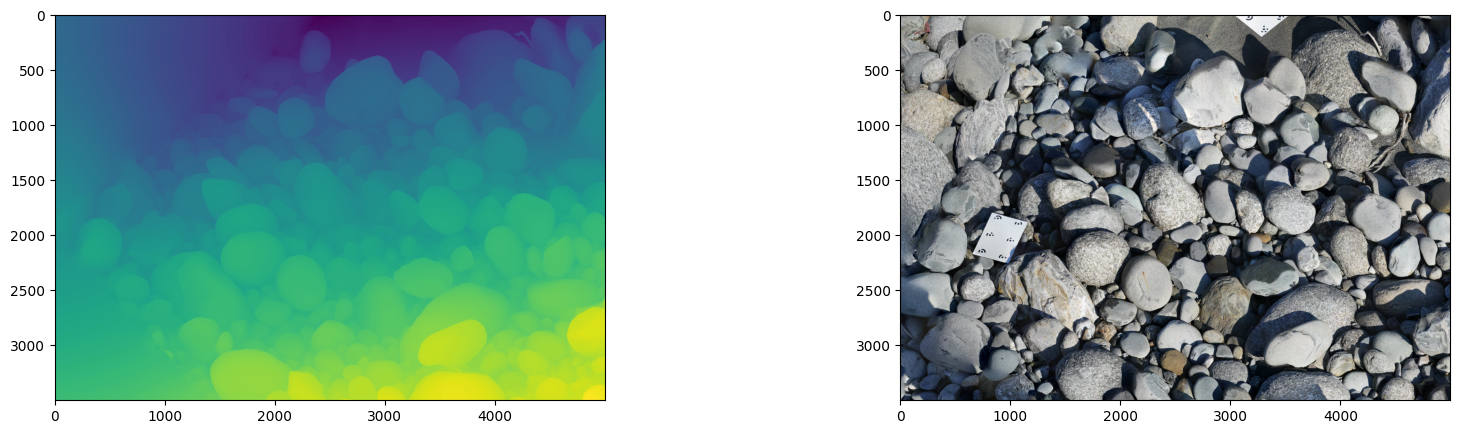

In [10]:
fig, ax=plt.subplots(1,2,figsize=(20,5))
ax[0].imshow(dem)
ax[1].imshow(image)

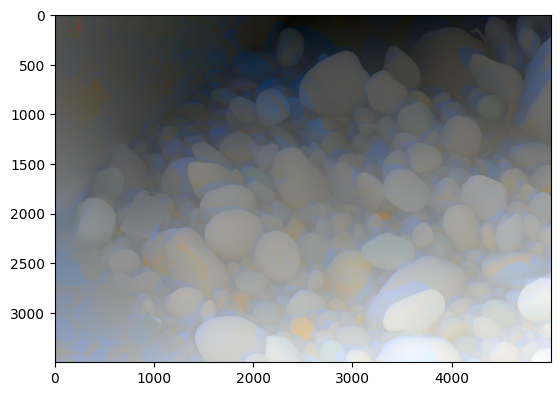

In [12]:
merged_lab = cv2.merge([uint_dem, a_channel, b_channel])
output = cv2.cvtColor(merged_lab, cv2.COLOR_LAB2RGB)
plt.imshow(output)

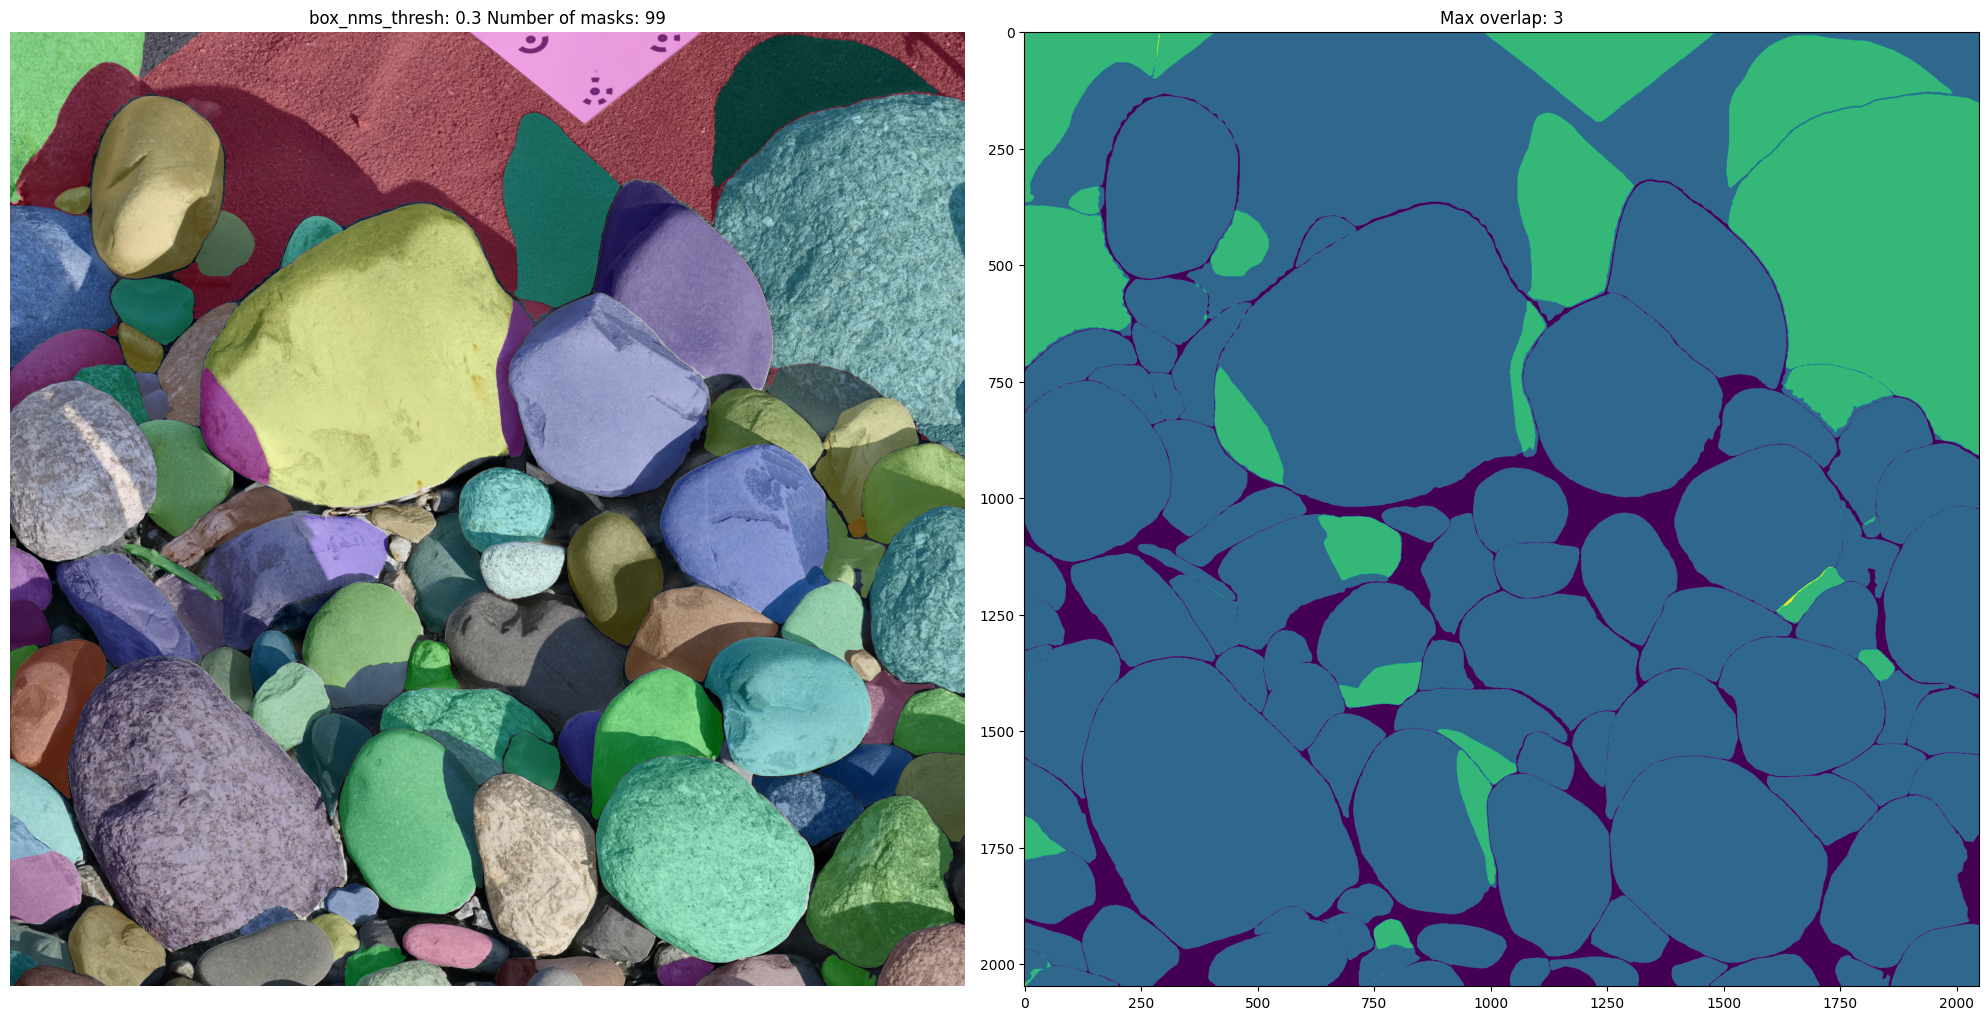

In [18]:
temp_image=fnc.preprocessing_roulette(output, 
                                      {'Crop': {'j':1}
                                       #'Gaussian': {'kernel size':3},
                                       #'CLAHE':{'clip limit':3}
                                       }
                                       )
rgb_image=fnc.preprocessing_roulette(image, 
                                      {'Crop': {'j':1}
                                       #'Gaussian': {'kernel size':3},
                                       #'CLAHE':{'clip limit':3}
                                       }
                                       )

var='box_nms_thresh'
test=[0.3]

fig, ax = plt.subplots(len(test),2,figsize=(20,10*len(test)))
ax=ax.flatten()

#build generator
for i in np.arange(0,len(test),1):
    #refresh memory
    gc.collect()
    torch.cuda.empty_cache()

    mask_generator = SamAutomaticMaskGenerator(
        model=sam,
        points_per_side=24,
        pred_iou_thresh=0.9,
        stability_score_thresh=0.9,#iou by varying cutoff in binary conversion
        box_nms_thresh=0.3,#The box IoU cutoff used by non-maximal suppression to filter duplicate masks
        crop_n_layers=0,#cut into 2**n crops
        crop_nms_thresh=0,#The box IoU cutoff used by non-maximal suppression to filter duplicate masks between crops
        crop_n_points_downscale_factor=1,
        crop_overlap_ratio=0,
        min_mask_region_area=2000,
    )
    with torch.no_grad():
        masks = mask_generator.generate(temp_image)
    ax[i*2].imshow(rgb_image)
    fnc.show_anns_mod_ax(masks, ax[i*2])
    ax[i*2].set_title(f'{var}: {test[i]} Number of masks: {len(masks)}')
    ax[i*2].axis('off')
    list_of_masks = [mask['segmentation'].astype(np.uint8) for mask in masks]
    ar_masks=np.stack(list_of_masks) 
    ax[i*2+1].imshow(np.sum(ar_masks,axis=0))
    ax[i*2+1].set_title(f'Max overlap: {np.unique(np.sum(ar_masks,axis=0)).max()}')       
plt.tight_layout()
plt.show()

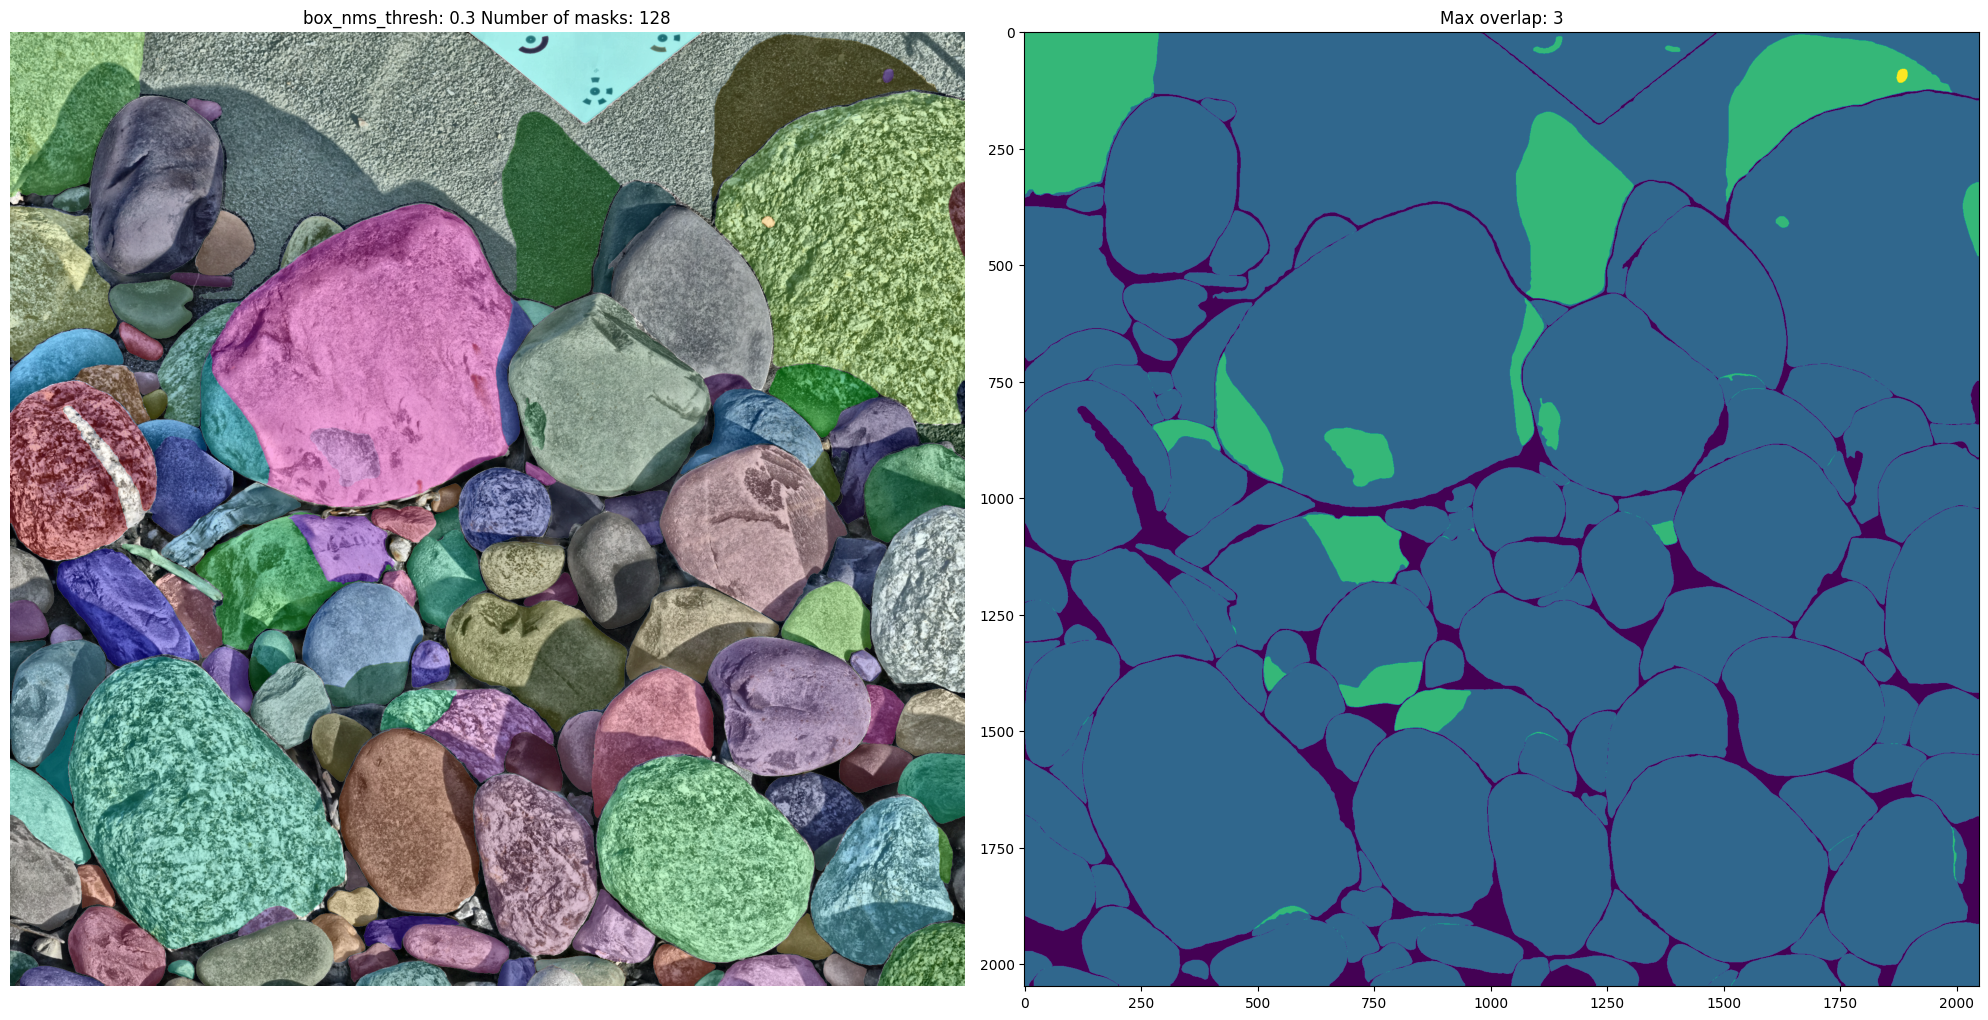

In [24]:
temp_image=fnc.preprocessing_roulette(image, 
                                      {'Crop': {'j':1},
                                       'Gaussian': {'kernel size':3},
                                       'CLAHE':{'clip limit':3}
                                       }
                                       )
rgb_image=fnc.preprocessing_roulette(image, 
                                      {'Crop': {'j':1},
                                       'Gaussian': {'kernel size':3},
                                       'CLAHE':{'clip limit':3}
                                       }
                                       )

var='box_nms_thresh'
test=[0.3]

fig, ax = plt.subplots(len(test),2,figsize=(20,10*len(test)))
ax=ax.flatten()

#build generator
for i in np.arange(0,len(test),1):
    #refresh memory
    gc.collect()
    torch.cuda.empty_cache()

    mask_generator = SamAutomaticMaskGenerator(
        model=sam,
        points_per_side=32,
        pred_iou_thresh=0.9,
        stability_score_thresh=0.9,#iou by varying cutoff in binary conversion
        box_nms_thresh=0.3,#The box IoU cutoff used by non-maximal suppression to filter duplicate masks
        crop_n_layers=0,#cut into 2**n crops
        crop_nms_thresh=0,#The box IoU cutoff used by non-maximal suppression to filter duplicate masks between crops
        crop_n_points_downscale_factor=1,
        crop_overlap_ratio=0,
        min_mask_region_area=2000,
    )
    with torch.no_grad():
        masks = mask_generator.generate(temp_image)
    ax[i*2].imshow(rgb_image)
    fnc.show_anns_mod_ax(masks, ax[i*2])
    ax[i*2].set_title(f'{var}: {test[i]} Number of masks: {len(masks)}')
    ax[i*2].axis('off')
    list_of_masks = [mask['segmentation'].astype(np.uint8) for mask in masks]
    ar_masks=np.stack(list_of_masks) 
    ax[i*2+1].imshow(np.sum(ar_masks,axis=0))
    ax[i*2+1].set_title(f'Max overlap: {np.unique(np.sum(ar_masks,axis=0)).max()}')       
plt.tight_layout()
plt.show()

In [ ]:
#grid search hillshade that creates a shadow mask with the lowest mean lightness value? to identify shadow area and pull it up

In [59]:
def hillshade(array,azimuth,angle_altitude):
    azimuth = 360.0 - azimuth 
    
    x, y = np.gradient(array)
    slope = np.pi/2. - np.arctan(np.sqrt(x*x + y*y))
    aspect = np.arctan2(-x, y)
    azm_rad = azimuth*np.pi/180. #azimuth in radians
    alt_rad = angle_altitude*np.pi/180. #altitude in radians
 
    shaded = np.sin(alt_rad)*np.sin(slope) + np.cos(alt_rad)*np.cos(slope)*np.cos((azm_rad - np.pi/2.) - aspect)
    
    return 255*(shaded + 1)/2

In [79]:
np.unique(norm_dem)

array([0.0000000e+00, 1.0523787e-05, 1.1013265e-05, ..., 9.9999696e-01,
       9.9999768e-01, 1.0000000e+00], dtype=float32)

In [131]:
hs_data = hillshade(norm_dem*1000,135,30)

In [132]:
np.unique(hs_data)

array([ 17.645447,  17.665047,  17.665388, ..., 254.99979 , 254.99982 ,
       254.99983 ], dtype=float32)

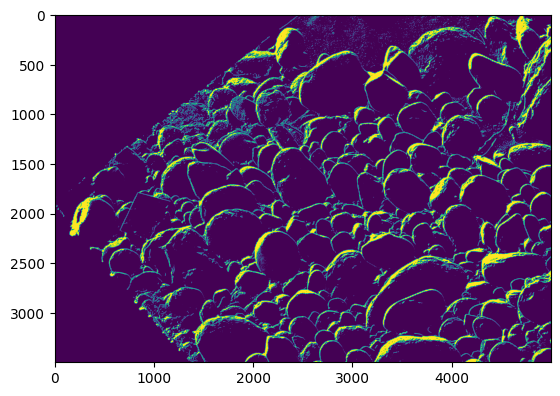

In [137]:
plt.imshow(hs_data<150)

In [134]:
hs_data<100

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

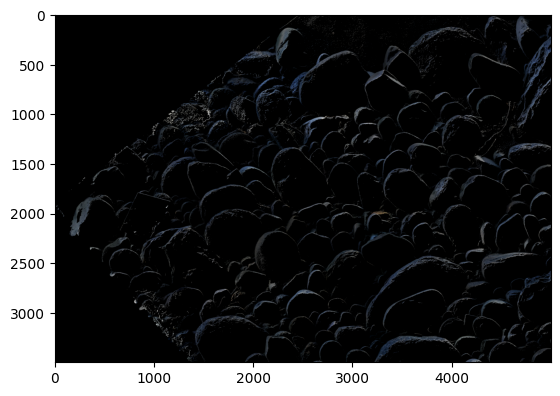

In [138]:
plt.imshow(image*(hs_data<150)[:,:,np.newaxis])